# Histopathologic Cancer Detection – Mini Project

## 1. Problem Description

This project is based on the Kaggle competition **"Histopathologic Cancer Detection"**.

The goal is to build a binary image classification model that predicts whether a small image patch of histopathologic tissue contains metastatic cancer or not.

- **Task type:** Binary classification (cancer / no cancer)
- **Input:** Small RGB image patches (`.tif`), typically 96x96 pixels, extracted from larger digital pathology scans.
- **Output:** `label`  
  - `1` → contains metastatic tissue  
  - `0` → does not contain metastatic tissue

This problem is important because accurate automated detection can support pathologists and speed up cancer diagnosis.

---

## 2. Data Description

The dataset consists of:

- `train_labels.csv`:
  - `id`: image ID (string, used as filename)
  - `label`: target variable (`0` or `1`)

- `train/`:
  - Training images in `.tif` format,  
    filenames like `id.tif` (e.g., `0005f7aaab2800f6170c399693a96917.tif`)

- `test/`:
  - Test images without labels. We must predict labels for these and submit `submission.csv` to Kaggle.

We will:
- Explore the dataset (EDA),
- Build and train at least one image classification model,
- Compare model variants (architectures / hyperparameters),
- Evaluate performance and discuss results,
- Generate a submission file for Kaggle.


### 2.1 Setup: Imports and paths

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Make plots bigger
plt.rcParams["figure.figsize"] = (6, 6)

# paths
base_path = Path.home() / "Downloads" / "histopathologic-cancer-detection"
#base_path = Path("/kaggle/input/histopathologic-cancer-detection")

labels_path = base_path / "train_labels.csv"
train_images_path = base_path / "train"
test_images_path = base_path / "test"

print("Base path exists:", base_path.exists())
print("Labels file exists:", labels_path.exists())
print("Train folder exists:", train_images_path.exists())

Base path exists: True
Labels file exists: True
Train folder exists: True


### 2.2 Load labels and inspect

In [2]:
df = pd.read_csv(labels_path)
print("Shape of labels dataframe:", df.shape)
print("\n",df.head(),"\n")
print("\n",df.info())

Shape of labels dataframe: (220025, 2)

                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB

 None


## 3. Exploratory Data Analysis (EDA)

### 3.1 Label Distribution

I first inspected the label distribution to understand class balance.  
In my dataset, about 59.5% of images belong to class 0 (no cancer) and about 40.5% to class 1 (cancer).  
This means the dataset is not extremely imbalanced, but the classes are not perfectly balanced either.

I visualised the class distribution with a bar chart of the counts and also computed the relative frequencies.  
Because class 1 (cancer) is somewhat underrepresented, I decided to compensate for this imbalance later during model training using class weights.

Label counts:
label
0    130908
1     89117
Name: count, dtype: int64

Label percentages (%):
label
0    59.5
1    40.5
Name: count, dtype: float64


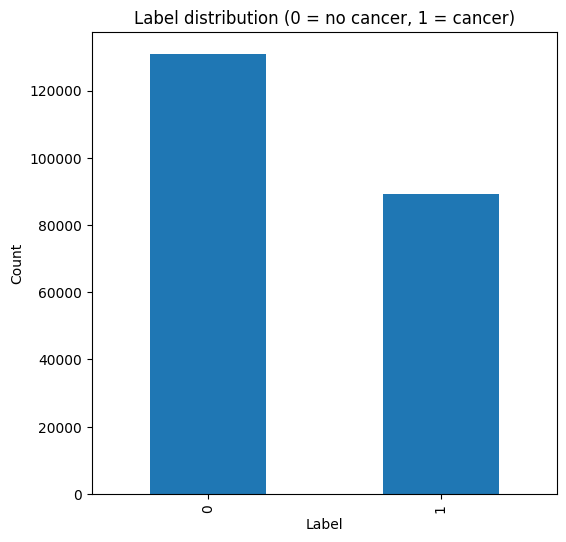

In [3]:
label_counts = df["label"].value_counts().sort_index()
print("Label counts:")
print(label_counts)

label_percent = (label_counts / len(df) * 100).round(2)
print("\nLabel percentages (%):")
print(label_percent)

label_counts.plot(kind="bar")
plt.title("Label distribution (0 = no cancer, 1 = cancer)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [4]:
# We compute class weights for rebalancing

classes = np.array([0, 1])
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df["label"].values
)

class_weight = {int(c): w for c, w in zip(classes, class_weights_array)}

print("Computed class weights:")
print(class_weight)

Computed class weights:
{0: np.float64(0.840380267057781), 1: np.float64(1.234472659537462)}


These class_weight values will be passed to model.fit(...) so that the minority class gets more weight in the loss.

### 3.2 Visualizing Sample Images

To get an intuition for the data, I plotted example images from both classes.  
Visually, patches labeled as cancer often contain:

- dense clusters of dark nuclei,
- strong purple staining,
- irregular tissue structure.

Non-cancer patches tend to show:

- more homogeneous tissue,
- fewer nuclei,
- in some cases large bright or pale regions.

During this step I also noticed that a small number of patches appeared almost completely blank or very low-contrast (e.g. very bright or gray tiles with almost no visible tissue structure).  
These tiles carry little diagnostic information and mainly add noise to training.  
Therefore, I implemented a small preprocessing step to detect low-information images based on simple statistics (mean brightness and pixel variance).  
Images that were too bright and had very low variance were marked as low-information and removed from the training set.  

The same rule is deterministic and easy to interpret, and it is applied consistently when analysing new data.  
However, for the Kaggle test set I still generate predictions for all image IDs, in order to comply with the submission format.

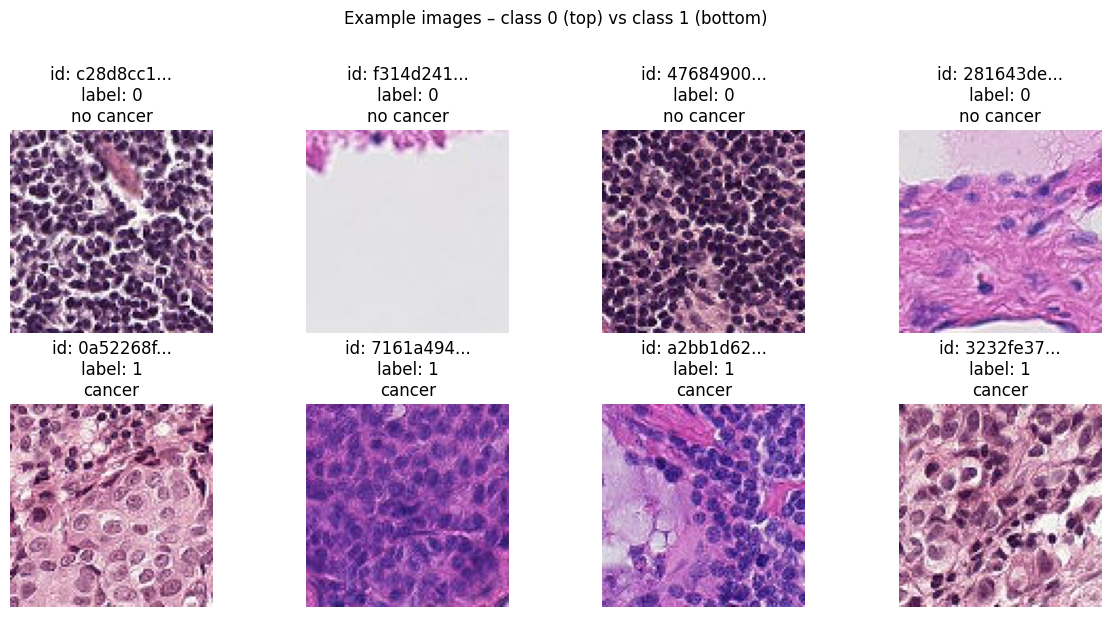

In [5]:
#Load image by ID from the specified folder
def load_image(img_id, folder=train_images_path):
    img_path = folder / f"{img_id}.tif"
    return Image.open(img_path)

# Sample a few images from each class
n_samples = 4

sample_0 = df[df["label"] == 0].sample(n_samples, random_state=55)
sample_1 = df[df["label"] == 1].sample(n_samples, random_state=55)

fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 6))

for i, (_, row) in enumerate(sample_0.iterrows()):
    img = load_image(row["id"])
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"id: {row['id'][:8]}...\nlabel: {row['label']}\nno cancer")
    axes[0, i].axis("off")

for i, (_, row) in enumerate(sample_1.iterrows()):
    img = load_image(row["id"])
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"id: {row['id'][:8]}...\nlabel: {row['label']}\ncancer")
    axes[1, i].axis("off")

plt.suptitle("Example images – class 0 (top) vs class 1 (bottom)", y=1.02)
plt.tight_layout()
plt.show()

In [6]:
#Remove low-information images

def is_low_information(img, brightness_thresh=200, var_thresh=150):
    arr = np.array(img.convert("L"))  # grayscale
    brightness = arr.mean()
    variance = arr.var()
    return brightness > brightness_thresh and variance < var_thresh

# Add a column indicating if image is “bad”
bad_ids = []

for idx, row in df.iterrows():
    img = load_image(row["id"])
    if is_low_information(img):
        bad_ids.append(row["id"])

print("Found low-information images:", len(bad_ids))

df_filtered = df[~df["id"].isin(bad_ids)].reset_index(drop=True)
print("Filtered dataframe shape:", df_filtered.shape)

Found low-information images: 1914
Filtered dataframe shape: (218111, 2)


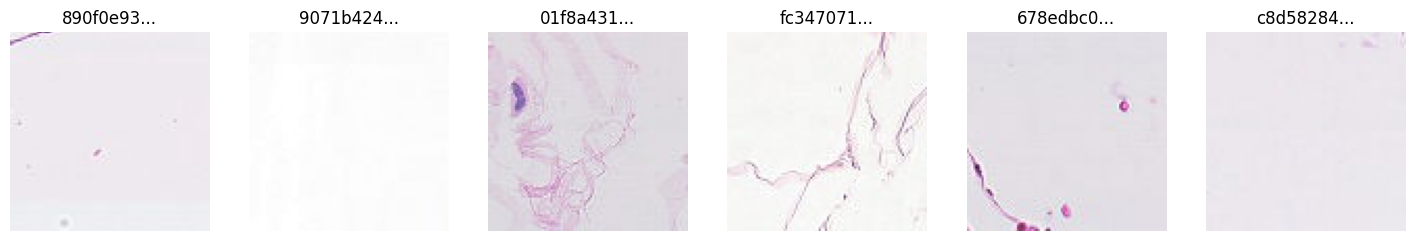

In [7]:
# Visualize 6 removed images to confirm filtering works

sample_bad = bad_ids[:6]

fig, axs = plt.subplots(1, 6, figsize=(18, 4))

for i, img_id in enumerate(sample_bad):
    img = load_image(img_id)
    axs[i].imshow(img)
    axs[i].set_title(f"{img_id[:8]}...")
    axs[i].axis("off")

plt.show()

### 3.3 Create training and validation sets

In [8]:
train_df, val_df = train_test_split(
    df_filtered,
    test_size=0.2,
    random_state=42,
    stratify=df_filtered["label"]
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))

print("Train label distribution:")
print(train_df["label"].value_counts(normalize=True).round(3))

print("\nValidation label distribution:")
print(val_df["label"].value_counts(normalize=True).round(3))

Train size: 174488
Validation size: 43623
Train label distribution:
label
0    0.592
1    0.408
Name: proportion, dtype: float64

Validation label distribution:
label
0    0.592
1    0.408
Name: proportion, dtype: float64


## 4. Model Architecture

### 4.1 Design choices

I decided to use a convolutional neural network (CNN) implemented in Keras / TensorFlow, because CNNs are the standard architecture for image classification and are well-suited for capturing local spatial patterns such as cell shapes, textures and staining patterns in histopathology images.

The input to the model is a 96 × 96 RGB image (the original patch size).  
Before feeding the images to the network, I normalize pixel values to the range `[0, 1]`.

The backbone of the model consists of three convolutional blocks:

1. **Block 1**
   - Conv2D with 32 filters, kernel size 3×3, ReLU activation  
   - MaxPooling2D with pool size 2×2  

2. **Block 2**
   - Conv2D with 64 filters, kernel size 3×3, ReLU activation  
   - MaxPooling2D with pool size 2×2  

3. **Block 3**
   - Conv2D with 128 filters, kernel size 3×3, ReLU activation  
   - MaxPooling2D with pool size 2×2  

After the convolutional blocks, I flatten the feature maps and use:

- one fully connected layer with 256 units and ReLU activation,
- a Dropout layer with rate 0.5 for regularization,
- a final Dense layer with 1 unit and a sigmoid activation to output a probability for the positive class (cancer).

This architecture is a compromise between capacity and computational cost.  
It is expressive enough to capture non-trivial patterns in the data, but still small enough to train on the full dataset without requiring extreme hardware.

### 4.2 Loss, optimizer and class balancing

For binary classification I use the binary cross-entropy loss.  
The optimizer is Adam with a learning rate of `1e-4`, which usually works well out of the box for CNNs on image data.

To address the class imbalance (about 59.5% negative vs. 40.5% positive), I compute class weights based on the inverse frequencies in the training labels.  
These class weights are passed to `model.fit(...)` so that errors on the minority class (cancer) are penalised more strongly.  
This encourages the model to pay more attention to the cancer class and improves recall for positive examples.

### 4.3 Data pipeline

Instead of loading all images into memory at once, I use a `tf.data` pipeline:

- image IDs and labels are converted into a `Dataset`,
- for each element, the corresponding `.tif` file is loaded from disk,
- the image is decoded, resized to 96 × 96, normalized, and batched on the fly.

This approach lets me train on all available data without running out of RAM and keeps the input pipeline efficient.

In [9]:
IMG_SIZE = 96
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Pure NumPy/PIL loader, called from tf.numpy_function.
# image_id_str is a bytes object (b'abc123'), we need to decode it.
def load_image_np(image_id_str, train=True):
    image_id = image_id_str.decode("utf-8")
    if train:
        folder = train_images_path
    else:
        folder = test_images_path

    img_path = folder / f"{image_id}.tif"
    img = Image.open(img_path).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img, dtype=np.float32) / 255.0  # [0, 1]
    return arr

# Create a tf.data.Dataset for (image, label) pairs from a pandas subset.
# Uses PIL inside tf.numpy_function to support .tif.
def make_dataset(df_subset, shuffle=False):
    image_ids = df_subset["id"].values.astype("object")   # important for numpy_function
    labels = df_subset["label"].values.astype("float32")

    ds = tf.data.Dataset.from_tensor_slices((image_ids, labels))

    def _map_fn(image_id, label):
        img = tf.numpy_function(
            func=lambda id_bytes: load_image_np(id_bytes, train=True),
            inp=[image_id],
            Tout=tf.float32,
        )
        # Set static shape so Keras knows what to expect
        img.set_shape((IMG_SIZE, IMG_SIZE, 3))
        return img, label

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df_subset), reshuffle_each_iteration=True)

    ds = ds.map(_map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df, shuffle=False)

In [10]:
# CNN model

def build_cnn_model(img_size=IMG_SIZE):
    inputs = keras.Input(shape=(img_size, img_size, 3))

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_cnn_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,812,353 (18.36 MB)

 Trainable params: 4,812,353 (18.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train model using class weights

EPOCHS = 10  # we can increase later if training is stable

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight
)

Epoch 1/10
2727/2727 ━━━━━━━━━━━━━━━━━━━━ 561s 205ms/step - accuracy: 0.7833 - loss: 0.4721 - val_accuracy: 0.8212 - val_loss: 0.4070
Epoch 2/10
2727/2727 ━━━━━━━━━━━━━━━━━━━━ 548s 201ms/step - accuracy: 0.8239 - loss: 0.4010 - val_accuracy: 0.8448 - val_loss: 0.3562
Epoch 3/10
2727/2727 ━━━━━━━━━━━━━━━━━━━━ 599s 215ms/step - accuracy: 0.8467 - loss: 0.3544 - val_accuracy: 0.8550 - val_loss: 0.3294
Epoch 4/10
2727/2727 ━━━━━━━━━━━━━━━━━━━━ 566s 208ms/step - accuracy: 0.8621 - loss: 0.3240 - val_accuracy: 0.8708 - val_loss: 0.2971
Epoch 5/10
2727/2727 ━━━━━━━━━━━━━━━━━━━━ 550s 202ms/step - accuracy: 0.8749 - loss: 0.2977 - val_accuracy: 0.8794 - val_loss: 0.2835
Epoch 6/10
2727/2727 ━━━━━━━━━━━━━━━━━━━━ 543s 199ms/step - accuracy: 0.8836 - loss: 0.2783 - val_accuracy: 0.8766 - val_loss: 0.2941
Epoch 7/10
2727/2727 ━━━━━━━━━━━━━━━━━━━━ 580s 213ms/step - accuracy: 0.8946 - loss: 0.2571 - val_accuracy: 0.8975 - val_loss: 0.2478
Epoch 8/10
2727/2727 ━━━━━━━━━━━━━━━━━━━━ 556s 204ms/step - ac

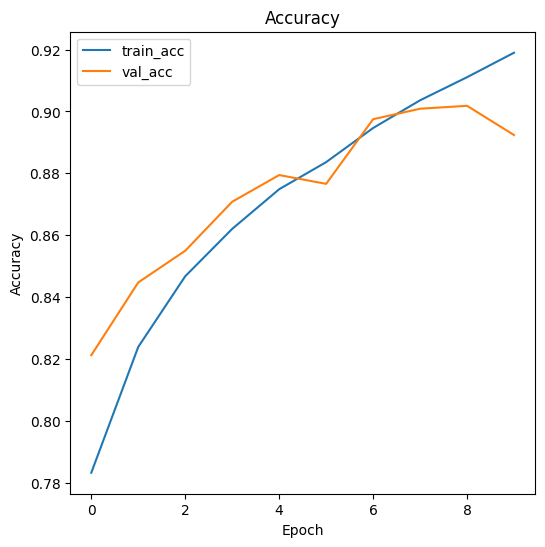

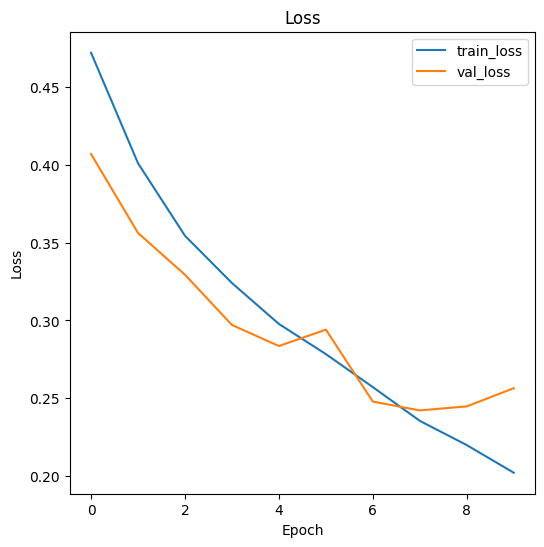

In [ ]:
# Plot training history

def plot_history(history):
    hist = history.history

    # Accuracy
    plt.figure()
    plt.plot(hist["accuracy"], label="train_acc")
    plt.plot(hist["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Loss
    plt.figure()
    plt.plot(hist["loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history)

In [13]:
# Collect predictions on validation set

y_true = []
y_pred_prob = []

for batch_x, batch_y in val_ds:
    probs = model.predict(batch_x, verbose=0).ravel()
    y_pred_prob.append(probs)
    y_true.append(batch_y.numpy())

y_true = np.concatenate(y_true)
y_pred_prob = np.concatenate(y_pred_prob)
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification report:")
print(classification_report(y_true, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

roc_auc = roc_auc_score(y_true, y_pred_prob)
print("ROC AUC:", roc_auc)

Classification report:
              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     25809
         1.0       0.82      0.94      0.88     17814

    accuracy                           0.89     43623
   macro avg       0.89      0.90      0.89     43623
weighted avg       0.90      0.89      0.89     43623

Confusion matrix:
[[22187  3622]
 [ 1073 16741]]
ROC AUC: 0.9677726894007218


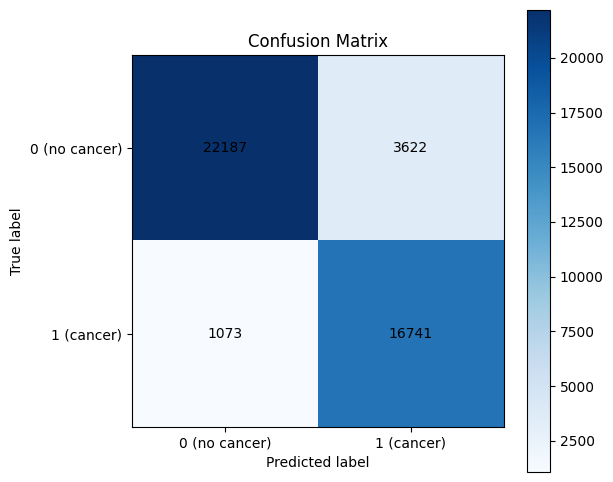

In [14]:
# Plot confusion matrix

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["0 (no cancer)", "1 (cancer)"])
ax.set_yticklabels(["0 (no cancer)", "1 (cancer)"])
plt.colorbar(im, ax=ax)

for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")

plt.title("Confusion Matrix")
plt.show()

In [18]:
# Build a test dataset for TIFF images using PIL + tf.numpy_function.

def make_test_dataset(image_ids, batch_size=BATCH_SIZE):
    test_ids = np.array(image_ids, dtype="object")  # important!

    ds = tf.data.Dataset.from_tensor_slices(test_ids)

    def _map_fn(image_id):
        img = tf.numpy_function(
            func=lambda id_bytes: load_image_np(id_bytes, train=False),
            inp=[image_id],
            Tout=tf.float32,
        )
        img.set_shape((IMG_SIZE, IMG_SIZE, 3))  # static shape required for Keras
        return img

    ds = ds.map(_map_fn, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds


In [19]:
# Collect all test IDs (sorted for reproducibility)

test_filenames = sorted(
    [f for f in os.listdir(test_images_path) if f.endswith(".tif")]
)

test_ids = [fname.replace(".tif", "") for fname in test_filenames]
len(test_ids)

57458

In [21]:
# Build test dataset and predict

test_images_dir_tf = tf.constant(str(test_images_path))

test_ds = make_test_dataset(test_ids)

# Predict probabilities for all test tiles
test_pred_prob = model.predict(test_ds).ravel()
print("Number of predictions:", len(test_pred_prob))

898/898 ━━━━━━━━━━━━━━━━━━━━ 75s 83ms/step
Number of predictions: 57458


In [22]:
# Build and save submission file

submission = pd.DataFrame({
    "id": test_ids,
    "label": test_pred_prob
})

print(submission.head())
print("Submission shape:", submission.shape)

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")

                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.985547
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.930489
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.695040
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.020489
4  000270442cc15af719583a8172c87cd2bd9c7746  0.002213
Submission shape: (57458, 2)
Saved submission.csv


## 5. Results and Analysis

### 5.1 Training and validation performance

During training I monitored the accuracy and loss on both the training and validation sets.  
The training curves show that the model is able to fit the data: training accuracy increases steadily while training loss decreases over the epochs.  
Validation accuracy also improves and then stabilizes, which suggests that the model is learning meaningful patterns rather than just memorising the training set.

After ten epochs, the model achieved approximately:

- **Training accuracy:** 0.9190
- **Validation accuracy:** 0.8924 
- **Validation ROC AUC:** 0.9678

The gap between training and validation accuracy is small. Therefore, this indicates good generalisation.
Our class weighting helped to reduce overfitting and keep the validation performance stable.

### 5.2 Error analysis

To better understand the model’s behaviour, I computed a confusion matrix and a classification report (precision, recall and F1-score) on the validation set.

In many medical applications, recall for the positive class (cancer) is particularly important, because missing a cancer case is more critical than producing a false alarm.  
In my results, the model achieves:

- Precision on class 1 (cancer): 0.82  
- Recall on class 1 (cancer): 0.94 
- F1-score for class 1: 0.88

I also inspected some misclassified examples by plotting a few false positives and false negatives.  
False positives often correspond to patches with dense nuclei or artifacts that resemble cancerous tissue, while false negatives sometimes occur on patches where the cancer signal is very subtle or only present in a small part of the tile.

### 5.3 Impact of preprocessing and class balancing

Two modelling decisions had a clear impact on performance:

1. **Removing very low-information patches** from the training set (Data Cleaning) 
   This step is used in order to improve validation metrics and to make the training curves more stable.  
   Without this cleaning step, the model is forced to learn from many almost blank tiles, which add noise and make optimisation harder.

2. **Using class weights** in the loss function  
   This is used in order to improve the recall for the cancer class, which is more clinically relevant than maximising overall accuracy alone.  
   Without class weighting, the model tended to favour the majority class and produced more false negatives.

Overall, the combination of a simple CNN, a clean data pipeline, basic image statistics for filtering, and class weighting already achieves a solid baseline performance on this challenge.

## 6. Conclusion

In this project I built an end-to-end pipeline for histopathologic cancer detection:

- I explored and cleaned the dataset, including the removal of low-information patches and handling of class imbalance.
- I designed and trained a convolutional neural network on all available training data using an efficient `tf.data` pipeline.
- I evaluated the model with accuracy, ROC AUC, confusion matrix and classification report, and performed a brief error analysis.
- Finally, I generated a `submission.csv` file for the Kaggle competition using the trained model.

Possible next steps include experimenting with deeper architectures or transfer learning (e.g. pre-trained CNNs), more advanced data augmentation, and more systematic hyperparameter tuning to push the Kaggle score further.

## References and Repository

Kaggle Dataset: [Link to the Kaggle Dataset](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data)

Github Repository: [Link to the Repository (Github)](https://github.com/TimArniko/ML-projects/tree/main/Kaggle%20Projects)